In [1]:
import pandas as pd
import sys
import requests
from io import StringIO
from tqdm.auto import tqdm
import re
import os

os.chdir("../")
sys.path.append("./src")

from data_fetching.sirene import get_company_info

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# Idée générale

Il s'agit dans ce notebook de mettre en place l'idée de cet [issue](https://github.com/dataforgoodfr/offseason_missiontransition_simulateur/issues/8). 

Formellement, entraîner un modèle qui à un couple `(aid, company)` est en mesure de rendre un `score` entre 0 et 1 representant les chances de succès de la demande d'aide pour savoir à quel point il est pertinent de proposer précisément cette `aid` à cette `company`.

# Préparation du dataset

## Données ADEME
Nous disposons d'un ensemble d'exemples de $n$ couples $\mathcal{S} = \{(a_i, c_i)\} _{i\leq n}$ qui ont fait l'objet d'une attribution de l'ADEME : pour tout $i\leq n$, l'entreprise $c_i$ a reçu l'aide $a_i$ proposée par l'ADEME.

Nous voulons créer un dataset labelisé, $\mathcal{D} = \{[(a_i, c_i), y_i]\}_{i\leq N}$ où $y_i$ représente les chances que l'entreprise $c_i$ obtienne (ou ait intérêt à obtenir) l'aide $a_i$.

$\mathcal{S}$ nous fournit un premier dataset avec des labels $y_i=1$, puisqu'il s'agit d'exemples où l'entreprise a effectivement obtenu l'aide en question.

Pour avoir un dataset complet, il faudrait avoir des exemples de couples $(a_i, c_i)$, avec un score $y_i$ inférieur à 1. 

## Exploration du dataset

In [3]:
### Dataset preparation

augmented_df = pd.read_csv("./data/augmented_dataset.csv", sep=";")

<IPython.core.display.Javascript object>

In [4]:
augmented_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   948 non-null    int64  
 1   dateConvention_ademe         948 non-null    object 
 2   nomBeneficiaire_ademe        948 non-null    object 
 3   montant_ademe                948 non-null    float64
 4   pourcentageSubvention_ademe  948 non-null    float64
 5   DEPET_ademe                  942 non-null    object 
 6   naf1etlib_ademe              942 non-null    object 
 7   naf2etlib_ademe              942 non-null    object 
 8   naf3etlib_ademe              942 non-null    object 
 9   naf4etlib_ademe              942 non-null    object 
 10  naf5etlib_ademe              942 non-null    object 
 11  id_mt                        948 non-null    int64  
 12  environmentalTopics_mt       948 non-null    object 
 13  fundingTypes_mt     

<IPython.core.display.Javascript object>

In [5]:
augmented_df.head()

,Unnamed: 0,dateConvention_ademe,nomBeneficiaire_ademe,montant_ademe,pourcentageSubvention_ademe,DEPET_ademe,naf1etlib_ademe,naf2etlib_ademe,naf3etlib_ademe,naf4etlib_ademe,naf5etlib_ademe,id_mt,environmentalTopics_mt,fundingTypes_mt,subventionRateUpperBound_mt,subventionRateLowerBound_mt,applicationStartDate_mt,result
0,0,2021-04-12,CLEMENT SAS,6500.0,1.0,71,Industrie manufacturière,Fabrication de machines et équipements n.c.a.,Fabrication de machines de formage des métaux ...,Fabrication de machines de formage des métaux,Fabrication de machines-outils pour le travail...,44,[{'name': 'Achat & location véhicules peu poll...,['Autre aide financière'],NaN,NaN,2021-11-09T15:42:49+00:00,1
1,1,2021-03-25,INDUSTRIE DOLOISE DE MICRO-MECANIQUE,12150.0,1.0,39,Industrie manufacturière,"Fabrication de produits métalliques, à l'excep...",Traitement et revêtement des métaux ; usinage,Usinage,Mécanique industrielle,44,[{'name': 'Achat & location véhicules peu poll...,['Autre aide financière'],NaN,NaN,2021-11-09T15:42:49+00:00,1
2,2,2021-03-23,TRANSDEV BFC SUD,16000.0,1.0,71,Transports et entreposage,Transports terrestres et transport par conduites,Autres transports terrestres de voyageurs,Autres transports terrestres de voyageurs n.c.a.,Transports routiers réguliers de voyageurs,44,[{'name': 'Achat & location véhicules peu poll...,['Autre aide financière'],NaN,NaN,2021-11-09T15:42:49+00:00,1
3,3,2021-03-23,LOCA TRAVAUX EURL,16400.0,1.0,90,Activités de services administratifs et de sou...,Activités de location et location-bail,"Location et location-bail d'autres machines, é...",Location et location-bail de machines et équip...,Location et location-bail de machines et équip...,44,[{'name': 'Achat & location véhicules peu poll...,['Autre aide financière'],NaN,NaN,2021-11-09T15:42:49+00:00,1
4,4,2021-03-26,RODESCHINI SAS,21500.0,1.0,70,Construction,Travaux de construction spécialisés,Autres travaux de construction spécialisés,Autres travaux de construction spécialisés n.c.a.,Travaux de maçonnerie générale et gros œuvre d...,44,[{'name': 'Achat & location véhicules peu poll...,['Autre aide financière'],NaN,NaN,2021-11-09T15:42:49+00:00,1


<IPython.core.display.Javascript object>

On se propose trois niveaux de modélisation :
1. Modélisation simple :

Features : `naf`, `environmentalTopics`, `fundingType`

2. Modélisation avec enrichissement par les données SIRENE :

Features : `naf`, `companyCategory` (PME, ...), `workforceSize`, `environmentalTopics`, `fundingTypes`

3. Modélisation fine avec NLP :

- Récupération du topic modeling de l'équipe de tagging
- (Ou) traitement NLP spécifique

# Modélisation

## Modèle simple

### Preprocessing
#### Explo

In [6]:
df_1 = augmented_df.copy()

<IPython.core.display.Javascript object>

In [7]:
df_1 = df_1.dropna(
    axis=0, subset=["naf1etlib_ademe", "environmentalTopics_mt", "fundingTypes_mt"]
)

<IPython.core.display.Javascript object>

In [8]:
len(df_1["naf1etlib_ademe"].unique())  # To onehot

18

<IPython.core.display.Javascript object>

In [9]:
def process_topics(topics):  # Get only names
    output = set()
    for topic in eval(topics):
        output.add(topic["name"])
    return output


df_1["environmentalTopics_mt"] = df_1["environmentalTopics_mt"].apply(
    process_topics
)  # To onehot

<IPython.core.display.Javascript object>

In [10]:
df_1["fundingTypes_mt"].apply(
    lambda x: len(eval(x))
).value_counts()  # Check if some rows have several funding types

1    928
2     14
Name: fundingTypes_mt, dtype: int64

<IPython.core.display.Javascript object>

In [11]:
df_1["fundingTypes_mt"] = df_1["fundingTypes_mt"].apply(eval)

<IPython.core.display.Javascript object>

#### Onehot encoding

In [12]:
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

<IPython.core.display.Javascript object>

In [13]:
encoder = OneHotEncoder(sparse=False)
output = encoder.fit_transform(df_1[["naf1etlib_ademe"]])
for i, category in enumerate(encoder.categories_[0]):
    df_1["naf1etlib_ademe_" + category] = list(output[:, i])

<IPython.core.display.Javascript object>

In [14]:
mlb_topics = MultiLabelBinarizer()
output = mlb_topics.fit_transform(df_1["environmentalTopics_mt"])
for i, topic in enumerate(mlb_topics.classes_):
    df_1["environmentalTopics_mt_" + topic] = list(output[:, i])

<IPython.core.display.Javascript object>

In [15]:
mlb_funding = MultiLabelBinarizer()
output = mlb_funding.fit_transform(df_1["fundingTypes_mt"])
for i, funding in enumerate(mlb_funding.classes_):
    df_1["fundingTypes_mt_" + funding] = list(output[:, i])

<IPython.core.display.Javascript object>

In [16]:
df_1.head()

,Unnamed: 0,dateConvention_ademe,nomBeneficiaire_ademe,montant_ademe,pourcentageSubvention_ademe,DEPET_ademe,naf1etlib_ademe,naf2etlib_ademe,naf3etlib_ademe,naf4etlib_ademe,...,environmentalTopics_mt_Réduction de la consommation d'énergie,environmentalTopics_mt_Réduction des pollutions & dépollution,environmentalTopics_mt_Réduction du gaspillage,environmentalTopics_mt_Réseaux de chaleur & Récupération de chaleur,environmentalTopics_mt_Sensibilisation & Formation,environmentalTopics_mt_Traitement & valorisation des biodéchets,"environmentalTopics_mt_Tri, recyclage, réemploi & réparation",fundingTypes_mt_Autre aide financière,fundingTypes_mt_Ingénierie technique,fundingTypes_mt_Subvention
0,0,2021-04-12,CLEMENT SAS,6500.0,1.0,71,Industrie manufacturière,Fabrication de machines et équipements n.c.a.,Fabrication de machines de formage des métaux ...,Fabrication de machines de formage des métaux,...,0,1,1,0,1,1,1,1,0,0
1,1,2021-03-25,INDUSTRIE DOLOISE DE MICRO-MECANIQUE,12150.0,1.0,39,Industrie manufacturière,"Fabrication de produits métalliques, à l'excep...",Traitement et revêtement des métaux ; usinage,Usinage,...,0,1,1,0,1,1,1,1,0,0
2,2,2021-03-23,TRANSDEV BFC SUD,16000.0,1.0,71,Transports et entreposage,Transports terrestres et transport par conduites,Autres transports terrestres de voyageurs,Autres transports terrestres de voyageurs n.c.a.,...,0,1,1,0,1,1,1,1,0,0
3,3,2021-03-23,LOCA TRAVAUX EURL,16400.0,1.0,90,Activités de services administratifs et de sou...,Activités de location et location-bail,"Location et location-bail d'autres machines, é...",Location et location-bail de machines et équip...,...,0,1,1,0,1,1,1,1,0,0
4,4,2021-03-26,RODESCHINI SAS,21500.0,1.0,70,Construction,Travaux de construction spécialisés,Autres travaux de construction spécialisés,Autres travaux de construction spécialisés n.c.a.,...,0,1,1,0,1,1,1,1,0,0


<IPython.core.display.Javascript object>

In [17]:
df_1.columns

Index(['Unnamed: 0', 'dateConvention_ademe', 'nomBeneficiaire_ademe',
       'montant_ademe', 'pourcentageSubvention_ademe', 'DEPET_ademe',
       'naf1etlib_ademe', 'naf2etlib_ademe', 'naf3etlib_ademe',
       'naf4etlib_ademe', 'naf5etlib_ademe', 'id_mt', 'environmentalTopics_mt',
       'fundingTypes_mt', 'subventionRateUpperBound_mt',
       'subventionRateLowerBound_mt', 'applicationStartDate_mt', 'result',
       'naf1etlib_ademe_Activités de services administratifs et de soutien',
       'naf1etlib_ademe_Activités financières et d'assurance',
       'naf1etlib_ademe_Activités immobilières',
       'naf1etlib_ademe_Activités spécialisées, scientifiques et techniques',
       'naf1etlib_ademe_Administration publique',
       'naf1etlib_ademe_Agriculture, sylviculture et pêche',
       'naf1etlib_ademe_Arts, spectacles et activités récréatives',
       'naf1etlib_ademe_Autres activités de services',
       'naf1etlib_ademe_Commerce ; réparation d'automobiles et de motocycles',
    

<IPython.core.display.Javascript object>

In [18]:
df_1 = df_1.iloc[:, 17:]

<IPython.core.display.Javascript object>

### Modeling

We will first try a classical Logistic Regression

#### Logistic Regression

In [19]:
X, y = df_1.iloc[:, 1:], df_1.iloc[:, 0]

<IPython.core.display.Javascript object>

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [21]:
from sklearn.linear_model import LogisticRegressionCV

logisticRegressionModel = LogisticRegressionCV(max_iter=1000, random_state=42)
logisticRegressionModel.fit(X_train, y_train)

LogisticRegressionCV(max_iter=1000, random_state=42)

<IPython.core.display.Javascript object>

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

<IPython.core.display.Javascript object>

In [23]:
def save_metrics(model, X, y):
    return dict(
        accuracy=accuracy_score(y, model.predict(X) > 0.5),
        precision=precision_score(y, model.predict(X) > 0.5),
        recall=recall_score(y, model.predict(X) > 0.5),
        f1=f1_score(y, model.predict(X) > 0.5),
    )


def evaluate_model(metrics):
    for metric in metrics:
        print(f"{metric} : {metrics[metric]:.4f}")

<IPython.core.display.Javascript object>

In [24]:
print("Train scores:")
train_lrm_metrics = save_metrics(logisticRegressionModel, X_train, y_train)
evaluate_model(train_lrm_metrics)

Train scores:
accuracy : 0.5471
precision : 0.5872
recall : 0.3613
f1 : 0.4473


<IPython.core.display.Javascript object>

In [25]:
print("Test scores:")
test_lrm_metrics = save_metrics(logisticRegressionModel, X_test, y_test)
evaluate_model(test_lrm_metrics)

Test scores:
accuracy : 0.5714
precision : 0.5714
recall : 0.3596
f1 : 0.4414


<IPython.core.display.Javascript object>

#### Random Forest & Gradient Boosting

In [26]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=1000, max_depth=50, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, n_estimators=1000, random_state=42)

<IPython.core.display.Javascript object>

In [27]:
print("Train scores:")
train_rfc_metrics = save_metrics(rfc, X_train, y_train)
evaluate_model(train_rfc_metrics)

Train scores:
accuracy : 0.7995
precision : 0.7824
recall : 0.8377
f1 : 0.8091


<IPython.core.display.Javascript object>

In [28]:
print("Test scores:")
test_rfc_metrics = save_metrics(rfc, X_test, y_test)
evaluate_model(test_rfc_metrics)

Test scores:
accuracy : 0.7566
precision : 0.7087
recall : 0.8202
f1 : 0.7604


<IPython.core.display.Javascript object>

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

<IPython.core.display.Javascript object>

In [30]:
print("Train scores:")
train_gbc_metrics = save_metrics(gbc, X_train, y_train)
evaluate_model(train_gbc_metrics)

Train scores:
accuracy : 0.7769
precision : 0.7378
recall : 0.8691
f1 : 0.7981


<IPython.core.display.Javascript object>

In [31]:
print("Test scores:")
test_gbc_metrics = save_metrics(gbc, X_test, y_test)
evaluate_model(test_gbc_metrics)

Test scores:
accuracy : 0.6984
precision : 0.6404
recall : 0.8202
f1 : 0.7192


<IPython.core.display.Javascript object>

#### Basic MLP

In [32]:
from sklearn.neural_network import MLPClassifier

mlpc = MLPClassifier(hidden_layer_sizes=(10, 256, 10), max_iter=500, random_state=42)
mlpc.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(10, 256, 10), max_iter=500, random_state=42)

<IPython.core.display.Javascript object>

In [33]:
print("Train scores:")
train_mlpc_metrics = save_metrics(mlpc, X_train, y_train)
evaluate_model(train_mlpc_metrics)

Train scores:
accuracy : 0.7981
precision : 0.7833
recall : 0.8325
f1 : 0.8071


<IPython.core.display.Javascript object>

In [34]:
print("Test scores:")
test_mlpc_metrics = save_metrics(mlpc, X_test, y_test)
evaluate_model(test_mlpc_metrics)

Test scores:
accuracy : 0.7672
precision : 0.7273
recall : 0.8090
f1 : 0.7660


<IPython.core.display.Javascript object>

### Résultats

In [35]:
df_results = pd.DataFrame(
    dict(
        logistic_regression=test_lrm_metrics,
        random_forest=test_rfc_metrics,
        gradient_boosting=test_gbc_metrics,
        neural_network=test_mlpc_metrics,
    )
)

<IPython.core.display.Javascript object>

In [36]:
df_results

,logistic_regression,random_forest,gradient_boosting,neural_network
accuracy,0.571429,0.756614,0.698413,0.767196
precision,0.571429,0.708738,0.640351,0.727273
recall,0.359551,0.820225,0.820225,0.808989
f1,0.441379,0.760417,0.719212,0.765957


<IPython.core.display.Javascript object>

Random Forest et le MLP semblent assez bien se dinstinguer avec une accuracy de 76% (bon indicateur ici puisque l'on est en présence d'un dataset équilibré).
Le rappel est supérieur à la précision, cela signifique que la modèle va avoir tendance à faire plus de faux négatif que de faux positifs, la question qu'il peut être pertinent de se poser c'est de savoir ce qu'on souhait privilégier

In [37]:
import seaborn as sns

<IPython.core.display.Javascript object>

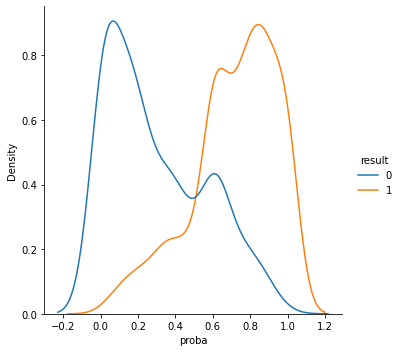

<IPython.core.display.Javascript object>

In [40]:
df_rfc = pd.DataFrame(dict(result=df_1["result"], proba=rfc.predict_proba(X)[:, 1]))
sns.displot(data=df_rfc, x="proba", hue="result", kind="kde")

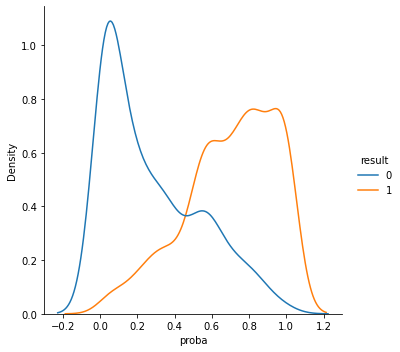

<IPython.core.display.Javascript object>

In [42]:
df_mlp = pd.DataFrame(dict(result=df_1["result"], proba=mlpc.predict_proba(X)[:, 1]))
sns.displot(data=df_mlp, x="proba", hue="result", kind="kde")

Franchement, c'est pas mal.